# Capstone Project
## Definition
### Project Overview
My project is my code for the [Kaggle Shelter Animal Outcomes contest](https://www.kaggle.com/c/shelter-animal-outcomes).  As described on Kaggle:
>Every year, approximately 7.6 million companion animals end up in US shelters. Many animals are given up as unwanted by their owners, while others are picked up after getting lost or taken out of cruelty situations. Many of these animals find forever families to take them home, but just as many are not so lucky. 2.7 million dogs and cats are euthanized in the US every year.

### Problem Statement
As described on Kaggle:
>Using a dataset of intake information including breed, color, sex, and age from the 
> [Austin Animal Center](http://www.austintexas.gov/department/animal-services), 
> we're asking Kagglers to predict the outcome for each animal.

### Metrics
As described on Kaggle:
> <p>Submissions are evaluated using the <a href="https://www.kaggle.com/wiki/MultiClassLogLoss">multi-class logarithmic loss</a>. Each incident has been labeled with one true class. For each animal, you must submit a set of predicted probabilities (one for every class). The formula is then,</p>
> <p>$$log loss = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij}),$$</p>
> <p>where N is the number of animals in the test set, M is the number of outcomes, \\(log\\) is the natural logarithm, \\(y_{ij}\\) is 1 if observation \\(i\\) is in outcome \\(j\\) and 0 otherwise, and $p_{ij}$ is the predicted probability that observation \\(i\\) belongs to outcome \\(j\\).</p>
> <p>The submitted probabilities for a given animal are not required to sum to one because they are rescaled prior to being scored (each row is divided by the row sum). In order to avoid the extremes of the log function, predicted probabilities are replaced with \\(max(min(p,1-10^{-15}),10^{-15})\\).</p>


## Analysis
### Data Exploration

In [36]:
%matplotlib inline
import pandas as pd 

data = pd.read_csv('../data/train.csv', parse_dates=['DateTime'])
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.0+ MB


From the data info, we can see that many of the animals have missing names.  This should not matter since it is unlikely that an animal's outcome would depend on its name.  The many mission OutcomeSubtype values should also not matter since we are only trying to predict the OutcomeType.  Finally, there is only one missing value for SexuponOutcome and 18 missing values for AgeuponOutcome.  We can probably drop these rows when training as there are so few.

### Exploratory Visualization

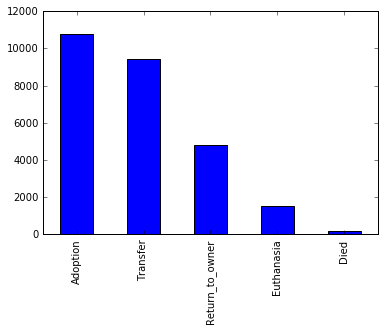

In [28]:
import numpy as np
import matplotlib.pyplot as plt

value_counts = data['OutcomeType'].value_counts()
value_counts.plot(kind='bar')

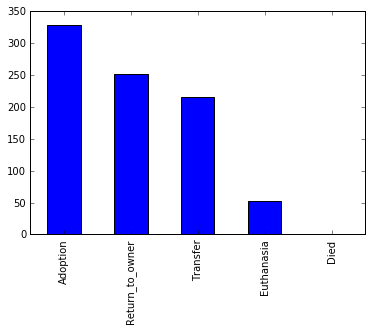

In [7]:
dog = data['AnimalType'] == "Dog"
black = data['Color'] == "Black"
black_dogs = data[black & dog]
black_dogs['OutcomeType'].value_counts().plot(kind='bar')

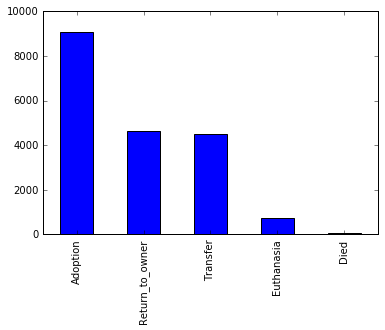

In [31]:
has_name = data['Name'].notnull()
named = data[has_name]
named['OutcomeType'].value_counts().plot(kind='bar')

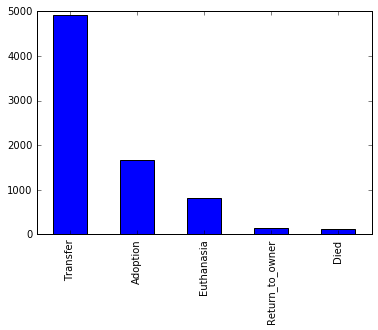

In [34]:
no_name = data['Name'].isnull()
un_named = data[no_name]
un_named['OutcomeType'].value_counts().plot(kind='bar')

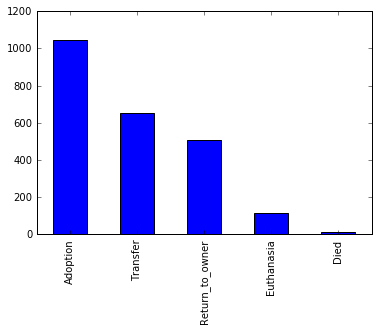

In [40]:
from util import get_month
data['Month'] = data['DateTime'].apply(get_month)
jan = data[data['Month'] == 1]
jan['OutcomeType'].value_counts().plot(kind='bar')

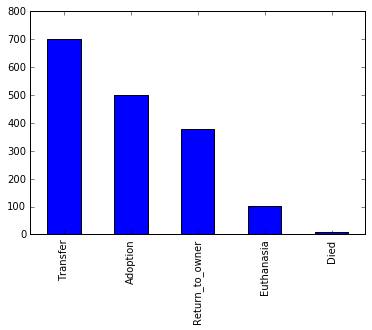

In [41]:
apr = data[data['Month'] == 4]
apr['OutcomeType'].value_counts().plot(kind='bar')

In [42]:
data['AnimalType'].unique()

array(['Dog', 'Cat'], dtype=object)

In [43]:
data['SexuponOutcome'].unique()

array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Unknown', nan], dtype=object)

In [44]:
data['AgeuponOutcome'].unique()

array(['1 year', '2 years', '3 weeks', '1 month', '5 months', '4 years',
       '3 months', '2 weeks', '2 months', '10 months', '6 months',
       '5 years', '7 years', '3 years', '4 months', '12 years', '9 years',
       '6 years', '1 weeks', '11 years', '4 weeks', '7 months', '8 years',
       '11 months', '4 days', '9 months', '8 months', '15 years',
       '10 years', '1 week', '0 years', '14 years', '3 days', '6 days',
       '5 days', '5 weeks', '2 days', '16 years', '1 day', '13 years', nan,
       '17 years', '18 years', '19 years', '20 years'], dtype=object)

In [88]:
data['Breed'].unique()
'Old English Sheepdog' in data['Breed'].unique()

True

In [46]:
len(data['Breed'].unique())

1380

In [47]:
data['Color'].unique()

array(['Brown/White', 'Cream Tabby', 'Blue/White', 'Blue Cream', 'Tan',
       'Black/Tan', 'Blue Tabby', 'Brown Tabby', 'Red/White', 'White',
       'Black', 'Silver', 'Brown', 'Black/Red', 'White/Cream',
       'Orange Tabby/White', 'Black/White', 'Brown Brindle/White',
       'Black/Brown', 'Orange Tabby', 'Chocolate/White', 'White/Tan',
       'Cream Tabby/White', 'Blue', 'Calico', 'Torbie', 'Brown/Black',
       'Yellow', 'Tricolor', 'White/Black', 'Tortie', 'Blue Tabby/White',
       'Gray/White', 'Tan/Black', 'Tan/White', 'Buff', 'Brown Tabby/White',
       'Red', 'Blue/Tan', 'Seal Point', 'Brown Brindle', 'White/Brown',
       'Gray', 'Yellow Brindle/White', 'Fawn/White', 'Flame Point',
       'Black Tabby/White', 'Tortie/Calico', 'Black/Brown Brindle',
       'White/Gray', 'Tan/Silver', 'Red Tick/Black', 'White/Cream Tabby',
       'Blue Merle', 'Chocolate/Tan', 'Sable', 'Brown Merle/White',
       'Brown Tiger/White', 'Liver/White', 'White/Blue Tabby',
       'Black/Gray', 'C

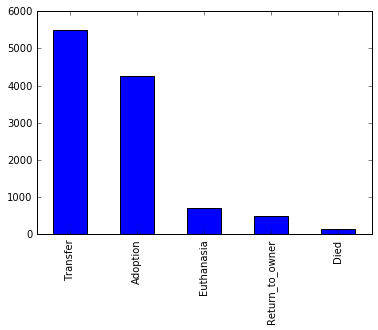

In [90]:
cats = data[data['AnimalType'] == "Cat"]
cats['OutcomeType'].value_counts().plot(kind='bar')

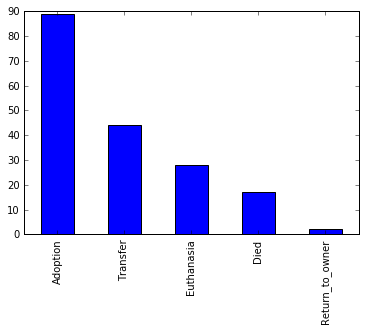

In [94]:
def get_hour(date_time):
    return date_time.hour
hour = cats['DateTime'].apply(get_hour)
cats.loc[:, 'Hour'] = hour
cats_at_eight = cats[cats['Hour'] == 8]
cats_at_eight['OutcomeType'].value_counts().plot(kind='bar')

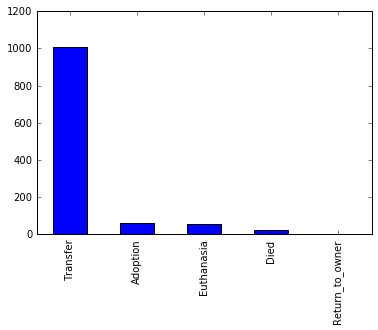

In [93]:
cats_at_nine = cats[cats['Hour'] == 9]
cats_at_nine['OutcomeType'].value_counts().plot(kind='bar')

### Algorithms and Techniques
### Benchmark
## Methodology
## Results
## Conclusion